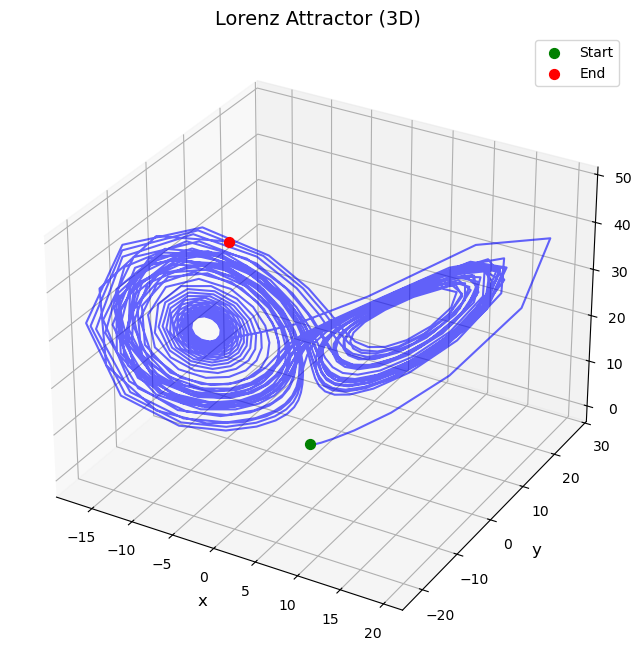

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection

# Lorenz system parameters
SIGMA = 10.0  # Controls the rate of convective turnover
R = 28.0      # Rayleigh number, related to temperature difference
B = 8.0 / 3.0 # Geometric factor

def lorenz_derivatives(state, time):
    """
    Compute the derivatives of the Lorenz system at a given state.

    Parameters:
        state (array-like): Current state [x, y, z].
        time (float): Current time (unused, included for consistency).

    Returns:
        np.ndarray: Derivatives [dx/dt, dy/dt, dz/dt].
    """
    x, y, z = state
    dx_dt = SIGMA * (y - x)
    dy_dt = R * x - y - x * z
    dz_dt = x * y - B * z
    return np.array([dx_dt, dy_dt, dz_dt])

def rk4_integrate(f, initial_cond, t_array):
    """
    Solve a system of ODEs using the 4th-order Runge-Kutta method.

    Parameters:
        f (callable): Function returning derivatives, with signature f(state, time).
        initial_cond (array-like): Initial conditions [x0, y0, z0].
        t_array (array-like): Array of time points.

    Returns:
        np.ndarray: Array of states [x, y, z] at each time point.
    """
    if len(initial_cond) != 3:
        raise ValueError("Initial conditions must have 3 components [x0, y0, z0].")
    if len(t_array) < 2:
        raise ValueError("Time array must have at least 2 points.")

    steps = len(t_array)
    dim = len(initial_cond)
    output = np.zeros((steps, dim))
    output[0] = initial_cond

    for j in range(1, steps):
        dt = t_array[j] - t_array[j - 1]
        state = output[j - 1]
        t = t_array[j - 1]
        k1 = f(state, t)
        k2 = f(state + 0.5 * dt * k1, t + 0.5 * dt)
        k3 = f(state + 0.5 * dt * k2, t + 0.5 * dt)
        k4 = f(state + dt * k3, t + dt)
        output[j] = state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return output

def plot_lorenz_attractor(initial_cond, t_max=50.0, num_points=1000, animate=False, figsize=(12, 6), dpi=300):
    """
    Simulate and visualize the Lorenz attractor in 2D and 3D.

    Parameters:
        initial_cond (list): Initial conditions [x0, y0, z0].
        t_max (float): Maximum time for simulation.
        num_points (int): Number of time points.
        animate (bool): If True, display an animated 3D plot.
        figsize (tuple): Figure size for plots.
        dpi (int): Resolution for saved plots.

    Returns:
        None: Generates and saves 2D and 3D plots.
    """
    # Generate time array
    t_array = np.linspace(0, t_max, num_points)

    # Solve the Lorenz system
    results = rk4_integrate(lorenz_derivatives, initial_cond, t_array)
    x_vals, y_vals, z_vals = results.T

    # Create 2D plots
    fig_2d, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot y vs time
    ax1.plot(t_array, y_vals, color='navy', linewidth=1.5)
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('y(t)', fontsize=12)
    ax1.set_title('y vs Time', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot z vs x with gradient colormap
    norm = plt.Normalize(0, t_max)
    points = np.array([x_vals, z_vals]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    line_collection = LineCollection(segments, cmap='viridis', norm=norm)
    line_collection.set_array(t_array)
    ax2.add_collection(line_collection)
    ax2.plot(x_vals[0], z_vals[0], 'go', label='Start', markersize=8)
    ax2.plot(x_vals[-1], z_vals[-1], 'ro', label='End', markersize=8)
    ax2.set_xlabel('x', fontsize=12)
    ax2.set_ylabel('z', fontsize=12)
    ax2.set_title('z vs x (Lorenz Attractor)', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(fontsize=10)
    fig_2d.colorbar(line_collection, ax=ax2, label='Time', shrink=0.5)

    plt.tight_layout()
    plt.savefig('lorenz_2d_plot.png', dpi=dpi, bbox_inches='tight')
    plt.close(fig_2d)

    # Create 3D plot
    fig_3d = plt.figure(figsize=(8, 8))
    ax_3d = fig_3d.add_subplot(111, projection='3d')
    
    if animate:
        # Initialize line for animation
        line, = ax_3d.plot([], [], [], 'b-', linewidth=1.5, alpha=0.6)
        ax_3d.plot([x_vals[0]], [y_vals[0]], [z_vals[0]], 'go', label='Start', markersize=8)
        ax_3d.plot([x_vals[-1]], [y_vals[-1]], [z_vals[-1]], 'ro', label='End', markersize=8)

        def init():
            """Initialize the animation."""
            line.set_data([], [])
            line.set_3d_properties([])
            return line,

        def update(frame):
            """Update the line for each animation frame."""
            line.set_data(x_vals[:frame+1], y_vals[:frame+1])
            line.set_3d_properties(z_vals[:frame+1])
            return line,

        # Create animation
        ani = FuncAnimation(fig_3d, update, init_func=init, frames=num_points, interval=10, blit=True)
        ax_3d.legend(fontsize=10)
        # Save animation as GIF (optional, requires pillow or imagemagick)
        # ani.save('lorenz_animation.gif', writer='pillow', fps=30)
    else:
        # Static 3D plot with gradient colormap
        points_3d = np.array([x_vals, y_vals, z_vals]).T
        ax_3d.plot(x_vals, y_vals, z_vals, linewidth=1.5, c='b', alpha=0.6)
        ax_3d.scatter([x_vals[0]], [y_vals[0]], [z_vals[0]], c='g', label='Start', s=50)
        ax_3d.scatter([x_vals[-1]], [y_vals[-1]], [z_vals[-1]], c='r', label='End', s=50)
        ax_3d.legend(fontsize=10)

    ax_3d.set_xlabel('x', fontsize=12)
    ax_3d.set_ylabel('y', fontsize=12)
    ax_3d.set_zlabel('z', fontsize=12)
    ax_3d.set_title('Lorenz Attractor (3D)', fontsize=14)
    plt.savefig('lorenz_3d_plot.png', dpi=dpi, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    # Example usage
    try:
        initial_cond = [0.0, 1.0, 0.0]
        plot_lorenz_attractor(initial_cond, t_max=50.0, num_points=1000, animate=False)
    except ValueError as e:
        print(f"Error: {str(e)}")